# Variational Autoencoders

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np

### The encoder

Our encoded has a 64 dimensions latent space.
The `z_mean` and `z_log_sigma` have both the 64 dimensions as well.
We are learning the $log(\sigma)$ instead of the $\sigma$ itself

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

Now we have to define a sampling layer. In our case we are going to use the 
$z = \mu + \sigma^2 * \epsilon$

In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Our encoder model composed by the $\sigma$, $\mu$ and the sampling layers.

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

Now we have to define our training loss. We are going to use a combinaition of the reconstruction loss (crossentropy) and the KL divergence

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Now we will pre-process the dataset and train our model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 222.5548 - val_loss: 166.6828
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 165.6354 - val_loss: 162.8223
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 161.9742 - val_loss: 160.3758
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 160.1299 - val_loss: 158.8728
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.8728 - val_loss: 158.0018
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 156.9772 - val_loss: 156.5444
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 155.8004 - val_loss: 155.3822
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 154.8116 - val_loss: 154.6850
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 153.8652 - val_loss: 153.6842
Epoch 10/100
1875/1875 [=============

In [ ]:
import matplotlib.pyplot as plt

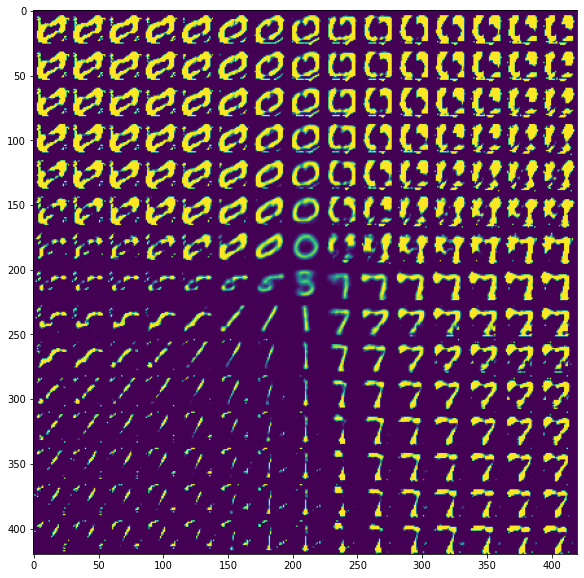

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


## Exercise

1. Apply the same VAE we just defined to the *fashion mnist* dataset and the [medical mnist](https://www.kaggle.com/andrewmvd/medical-mnist)
1. Create a VAE for generating fingerprints, using the data from the previous exercise (the one from the autoencoders lesson)